In [9]:
import numpy as np
from fugu import Scaffold
from fugu.bricks.input_bricks import Vector_Input
from fugu.bricks.dense_bricks import dense_layer_1d
from fugu.backends import snn_Backend
import networkx as nx
import matplotlib.pyplot as plt

# Parametrize network dimensions
input_size = 1
output_size = 1
n_steps = 100

# Create input spikes: each neuron spikes 5 times at random times
np.random.seed(42)
spikes = np.zeros((input_size, n_steps))
for i in range(input_size):
    spike_times = np.random.choice(n_steps, size=5, replace=False)
    spikes[i, spike_times] = 1

print('Input spikes:')
for i in range(input_size):
    print(f'Neuron {i}:', np.where(spikes[i] == 1)[0])

# Build scaffold and add input brick
scaffold = Scaffold()
scaffold.add_brick(
    Vector_Input(spikes, coding='Raster', name='Input', time_dimension=True),
    input_nodes='input'
 )

# Add output layer brick (fully connected to input)
W = np.random.uniform(1.0, 3.0, (output_size, input_size))   # Random weights between 1 and 3
T = np.random.uniform(0.1, 0.5, output_size)                  # Random thresholds between 0.1 and 0.5
scaffold.add_brick(
    dense_layer_1d(output_shape=(output_size,), weights=W, thresholds=T, name='Output'),
    input_nodes=[-1],
    output=True
)



print("Weights:", W)
print("Thresholds:", T)

# Build the network graph
scaffold.lay_bricks()

# print all edges
print('Network edges (source → target):')
for u, v, d in scaffold.graph.edges(data=True):
    print(f'{u} → {v} | weight={d.get("weight")} | delay={d.get("delay")}')

for n, props in scaffold.graph.nodes(data=True):
    if "Outputd" in str(n):
        props['layer'] = 'input'   # trick backend into treating them as InputNeurons


# Run simulation
backend = snn_Backend()
backend.compile(scaffold, compile_args={'record': 'all', 'debug_mode': True})

# This call is done inside compile(), but do it again explicitly to see prints:
backend.set_input_spikes()

result = backend.run(n_steps=n_steps)

print('Simulation result (all spike times):')
for neuron, spikes in result.items():
    print(f'{neuron}: {spikes}')

# If available, print membrane potentials for output neurons
if hasattr(backend, 'get_potentials') and callable(getattr(backend, 'get_potentials')):
    potentials = backend.get_potentials()
    print('Output neuron membrane potentials:')
    print(potentials)

Input spikes:
Neuron 0: [44 45 53 70 83]
Weights: [[1.39768481]]
Thresholds: [0.38453678]
Num of output neurons 1
Network edges (source → target):
Input-4:begin → Input-4:complete | weight=1.0 | delay=99
Input-4:begin → Output_begin | weight=0.0 | delay=1
Input-4:complete → Output_complete | weight=0.0 | delay=1
Input-4:(0,) → Outputd0 | weight=1.3976848081776103 | delay=1
Input-4:(0,) [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Neurons: {Input-4:(0,), Input-4:begin, Input-4:complete, Output_begin, Output_complete, Outputd0}
Input-4:(0,) [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
print("Input neurons in fugu_circuit:")
for n, props in backend.fugu_circuit.nodes(data=True):
    if props.get("layer") == "input":
        print(n)


Input neurons in fugu_circuit:
0


Filtered NetworkX graph nodes:
['Input-4:begin', 'Input-4:complete', 'Input-4:(0,)', 'Output_begin', 'Output_complete', 'Outputd0']
Filtered NetworkX graph edges:
[('Input-4:begin', 'Input-4:complete', {'weight': 1.0, 'delay': 99}), ('Input-4:begin', 'Output_begin', {'weight': 0.0, 'delay': 1}), ('Input-4:complete', 'Output_complete', {'weight': 0.0, 'delay': 1}), ('Input-4:(0,)', 'Outputd0', {'weight': np.float64(1.3976848081776103), 'delay': 1})]


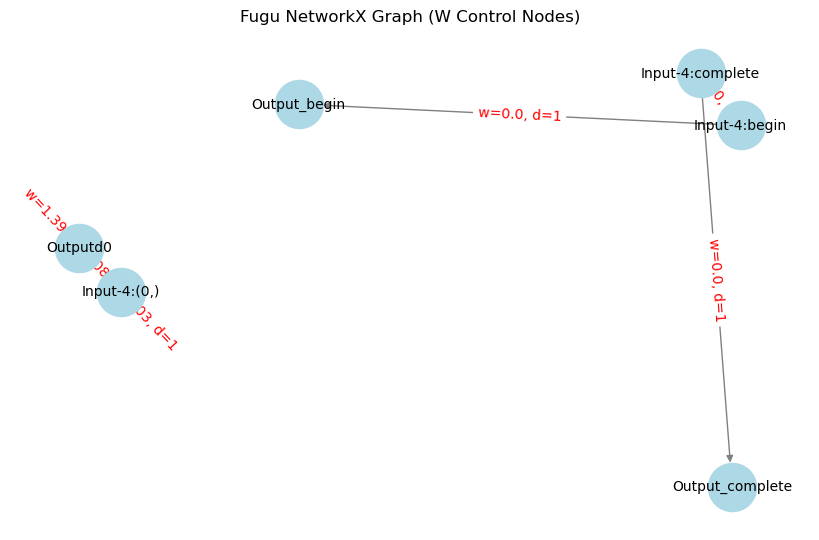

In [11]:
# Print and visualize the networkx graph (excluding control nodes/edges)
def is_control_node(node):
    return isinstance(node, str) and (node.__contains__('begin') or node.__contains__('complete') or node.startswith('control'))

def filter_graph(graph):
    # Remove control nodes and edges
    nodes = [n for n in graph.nodes() if not is_control_node(n)]
    edges = [(u, v) for u, v in graph.edges() if not is_control_node(u) and not is_control_node(v)]
    subgraph = graph.subgraph(nodes).copy()
    return subgraph

# filtered_graph = filter_graph(scaffold.graph)
filtered_graph = scaffold.graph

print('Filtered NetworkX graph nodes:')
print(filtered_graph.nodes())
print('Filtered NetworkX graph edges:')
print(filtered_graph.edges(data=True))
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(filtered_graph)
nx.draw(filtered_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1200, font_size=10)
edge_labels = {(u, v): f'w={d.get("weight")}, d={d.get("delay")}' for u, v, d in filtered_graph.edges(data=True)}
nx.draw_networkx_edge_labels(filtered_graph, pos, edge_labels=edge_labels, font_color='red')
plt.title('Fugu NetworkX Graph (W Control Nodes)')
plt.show()

In [ ]:
import numpy as np
from fugu import Scaffold
from fugu.bricks.input_bricks import Vector_Input
from fugu.bricks.dense_bricks import dense_layer_1d
from fugu.backends import snn_Backend

T = 12
spikes = np.zeros((1, T), dtype=int)
spikes[05] = 1

W  = np.array([[5.0]])
Th = np.array([0.2])

scaffold = Scaffold()
inp = scaffold.add_brick(Vector_Input(spikes, name='Input', time_dimension=True))
out = scaffold.add_brick(dense_layer_1d(output_shape=(1,), weights=W, thresholds=Th, name='Output'))
scaffold.connect(inp, out)
scaffold.lay_bricks()

backend = snn_Backend()
backend.compile(scaffold, compile_args={'record': 'all', 'debug_mode': True})

# ---------- INSERT BLOCK A: set neuron params (AFTER compile, BEFORE run) ----------
# If backend.set_properties works in your tree, use the tag:
try:
    tag = scaffold.name_to_tag['Output']
    backend.set_properties({ tag: {'decay': 0.0, 'threshold': 0.2, 'reset_voltage': 0.0, 'p': 1.0} })
except TypeError:
    # If Brick.set_properties is broken in your fork, set directly on the sim:
    for name, n in backend.nn.nrns.items():
        if name.startswith('Outputd'):
            n.threshold = 0.2
            n.leakage_constant = 1.0   # decay=0.0 -> retain=1.0
            n.reset_voltage = 0.0
            n.p = 1.0
# -------------------------------------------------------------------------------

# ---------- INSERT BLOCK B: HOTFIX input injection (AFTER compile, BEFORE run) ----------
# This bypasses CalculateSpikeTimes name-mismatch; feed your spikes directly.
for key, vals in backend.fugu_circuit.nodes.data():
    if vals.get('layer') != 'input':
        continue
    port = next(iter(vals['ports'].values()))
    data_ch = port.channels['data']
    for i, neuron in enumerate(data_ch.neurons):
        backend.nn.update_input_neuron(neuron, spikes[i].tolist())
# -------------------------------------------------------------------------------

# Run with potentials for visibility
st, V = backend.run(n_steps=T, return_potentials=False)
print("Spike times:\n", st)



Num of output neurons 1
Spike times:
 time
